<a href="https://colab.research.google.com/github/krc8771/ML4CyberAnalytics/blob/main/4_27.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
# import important packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

from google.colab import drive
from google.colab import auth
from google.colab import data_table
data_table.enable_dataframe_formatter()
from oauth2client.client import GoogleCredentials

!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [2]:
#Mount Google Drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
#Read Data from Google Drive
# Code to read csv file into Colaboratory:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
# Load dataset
path = "/content/gdrive/MyDrive/ML4CyberAnalytics/205.174.165.80/CICDataset/CIC-IDS-2017/Dataset/MachineLearningCSV.zip (Unzipped Files)/MachineLearningCVE/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv"
data = pd.read_csv(path, index_col=None, header=0, encoding='latin 1', skipinitialspace=True)
#X = data.drop(["Destination Port", "Bwd PSH Flags", "Fwd URG Flags", "Bwd URG Flags",
#               "FIN Flag Count", "SYN Flag Count", "RST Flag Count", "PSH Flag Count",
#               "ACK Flag Count", "URG Flag Count", "CWE Flag Count", "ECE Flag Count", 
#               "Init_Win_bytes_backward", "Fwd Avg Bytes/Bulk", "Fwd Avg Packets/Bulk", 
#               "Fwd Avg Bulk Rate", "Bwd Avg Bytes/Bulk", "Bwd Avg Packets/Bulk", 
#               "Bwd Avg Bulk Rate", "Fwd PSH Flags"], axis=1)

In [5]:
X = data[["Flow Duration", "Total Fwd Packets", "Total Backward Packets",
       "Total Length of Fwd Packets", "Total Length of Bwd Packets",
       "Fwd Packet Length Max", "Fwd Packet Length Min",
       'Fwd Packet Length Mean', 'Fwd Packet Length Std',
       'Bwd Packet Length Max', 'Bwd Packet Length Min',
       'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s',
       'Flow Packets/s', "Label"]]

# Next Steps


In [6]:
for col in X.loc[:1]:
  if X[col].name != 'Label':
    filter_low = X[col].quantile(0.01)
    filter_high = X[col].quantile(0.99)
    #print("dropIdx= " + X[(X[col] < filter_high) & (X[col] > filter_low)])
    X_filtered = X[(X[col] < filter_high) & (X[col] > filter_low)]
    #print(X_filtered)
    #X_filtered = X[(X[col] < filter_high) & (X[col] > filter_low)]['Label']

    X_filtered[col].fillna(X_filtered[col].mean())
    X_filtered[col].replace([np.inf], X_filtered[col].max(), inplace=True)
    X_filtered[col].replace([-np.inf], X_filtered[col].min(), inplace=True)

from sklearn.preprocessing import OrdinalEncoder

ord_enc = OrdinalEncoder()
X_filtered['Label'] = ord_enc.fit_transform(X_filtered[['Label']])

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_filtered)
scaled_X_df = pd.DataFrame(X_scaled, columns=X_filtered.columns, index=X_filtered.index)


/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


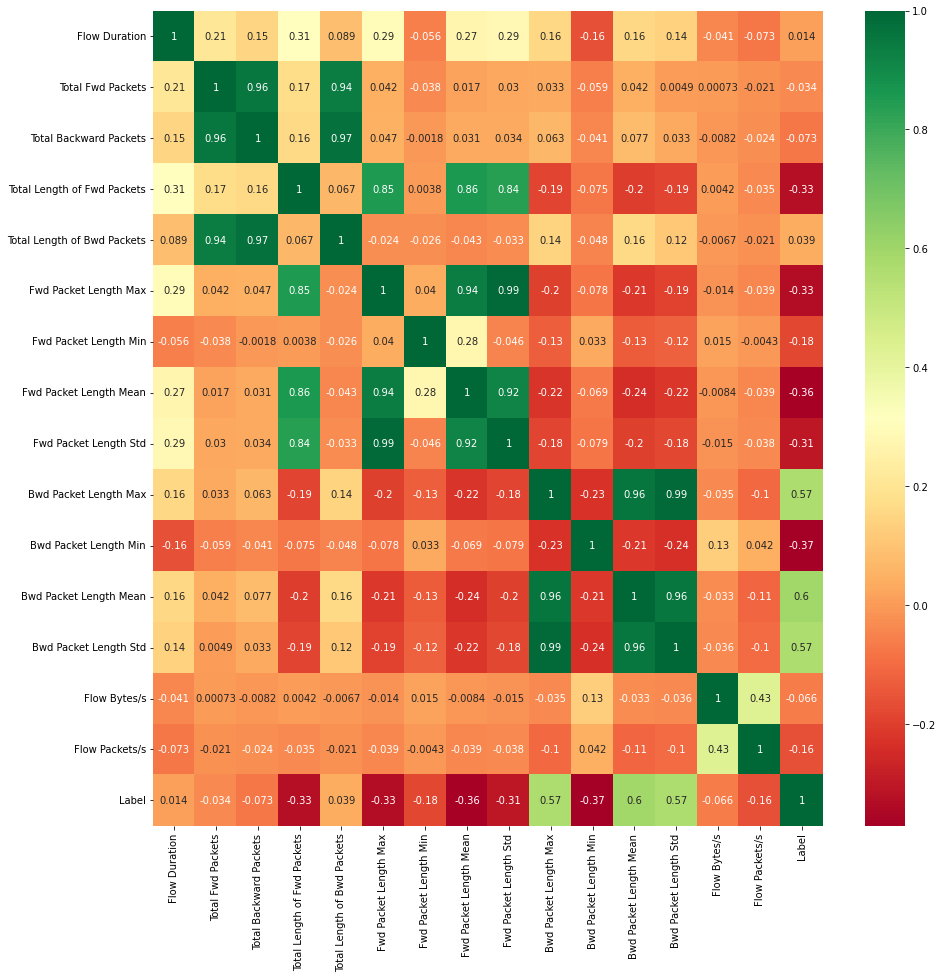

In [7]:
X = scaled_X_df.iloc[:,0:16]  #independent columns
y = scaled_X_df.iloc[:,-1]    #target column i.e label
#get correlations of each features in dataset
corrmat = scaled_X_df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(15,15))
#plot heat map
g=sb.heatmap(scaled_X_df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [8]:
scaled_X_df = scaled_X_df[['Flow Duration', 'Total Length of Bwd Packets', 'Bwd Packet Length Max', 'Bwd Packet Length Mean', 'Bwd Packet Length Std','Label']]


In [9]:
y = scaled_X_df['Label']
X = scaled_X_df.drop('Label',axis=1)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [10]:
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98     28476
         1.0       0.99      0.99      0.99     37878

    accuracy                           0.99     66354
   macro avg       0.99      0.99      0.99     66354
weighted avg       0.99      0.99      0.99     66354



# Data Visualization & Perturbations


In [ ]:
plt.figure(figsize=(15,15))
plt.suptitle('Benign & DDoS Data', fontsize=20)
for i,col in enumerate(scaled_X_df.columns):
  i = i+1
  plt.subplot(3,3,i)
  plt.hist(scaled_X_df[col], bins=10)
  plt.title(col)  

In [ ]:
benDf = scaled_X_df.loc[scaled_X_df['Label'] == 0.0]
dosDf = scaled_X_df.loc[scaled_X_df['Label'] == 1.0]

plt.figure(figsize=(15,15))
plt.suptitle('Benign Data', fontsize=20, va='center', ha='left')
for i,col in enumerate(benDf.columns):
  i = i+1
  plt.subplot(3,3,i)
  plt.hist(benDf[col], bins=10)
  plt.title(col) 

plt.figure(figsize=(15,15))
plt.suptitle('DDoS Data', fontsize=20)
for i,col in enumerate(dosDf.columns):
  i = i+1
  plt.subplot(3,3,i)
  plt.hist(dosDf[col], bins=10)
  plt.title(col) 

In [187]:
import random
attackFeatures = ['Bwd Packet Length Max', 'Bwd Packet Length Mean', 'Bwd Packet Length Std']
malDf = scaled_X_df
#malDf = X_train
#dict of feature min, max, mean, and std
df_featDict = {}

for feature in attackFeatures:
  df_featDict[feature] = [scaled_X_df[feature].min(), scaled_X_df[feature].max(), 
                          scaled_X_df[feature].mean(), scaled_X_df[feature].std()]
  for i, rowVal in enumerate(malDf[feature]):
    if malDf.iat[i, 5] == 1.0:
      malDf.iat[i, malDf.columns.get_loc(feature)] = random.uniform(df_featDict[feature][0], df_featDict[feature][1]) 


              precision    recall  f1-score   support

         0.0       0.67      1.00      0.80     28476
         1.0       1.00      0.63      0.77     37878

    accuracy                           0.79     66354
   macro avg       0.84      0.82      0.79     66354
weighted avg       0.86      0.79      0.79     66354



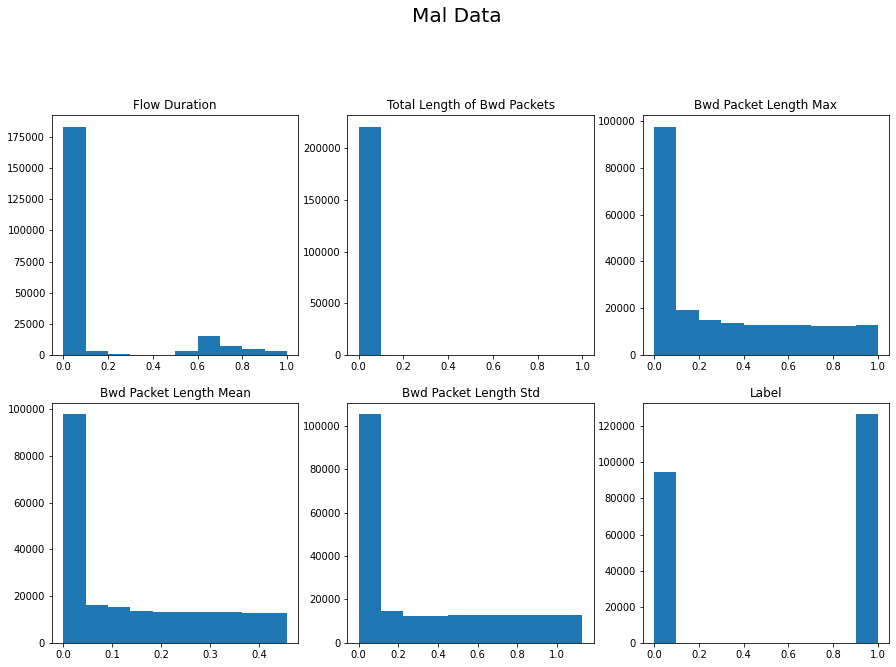

In [188]:
plt.figure(figsize=(15,15))
plt.suptitle('Mal Data', fontsize=20)
for i,col in enumerate(malDf.columns):
  i = i+1
  plt.subplot(3,3,i)
  plt.hist(malDf[col], bins=10)
  plt.title(col) 

y_mal = malDf['Label']
X_mal = malDf.drop('Label',axis=1)


X_train_mal, X_test_mal, y_train_mal, y_test_mal = train_test_split(X_mal, y_mal, test_size=0.3, random_state=0)

clf_mal = RandomForestClassifier(n_estimators=100)
clf_mal.fit(X_train_mal, y_train_mal)
print(classification_report(y_test, clf_mal.predict(X_test)))

In [11]:
import random
attackFeatures = ['Bwd Packet Length Max', 'Bwd Packet Length Mean', 'Bwd Packet Length Std']

mean_range = scaled_X_df['Bwd Packet Length Mean']
mean_low = 0
mean_high = 0.15
max_low = 0
max_high = 0.2
std_low = 0
std_high = 0.13

malDf2 = scaled_X_df
df2_featDict = {'Bwd Packet Length Max': [max_low, max_high],
                'Bwd Packet Length Mean': [mean_low, mean_high],
                'Bwd Packet Length Std': [std_low, std_high]}

for feature in attackFeatures:
  for i, rowVal in enumerate(malDf2[feature]):
    if malDf2.iat[i, 5] == 1.0:
      #print(malDf.columns.get_loc(feature))
      malDf2.iat[i, malDf2.columns.get_loc(feature)] = random.uniform(df2_featDict[feature][0], df2_featDict[feature][1])

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.43      1.00      0.60     28476
         1.0       0.00      0.00      0.00     37878

    accuracy                           0.43     66354
   macro avg       0.21      0.50      0.30     66354
weighted avg       0.18      0.43      0.26     66354



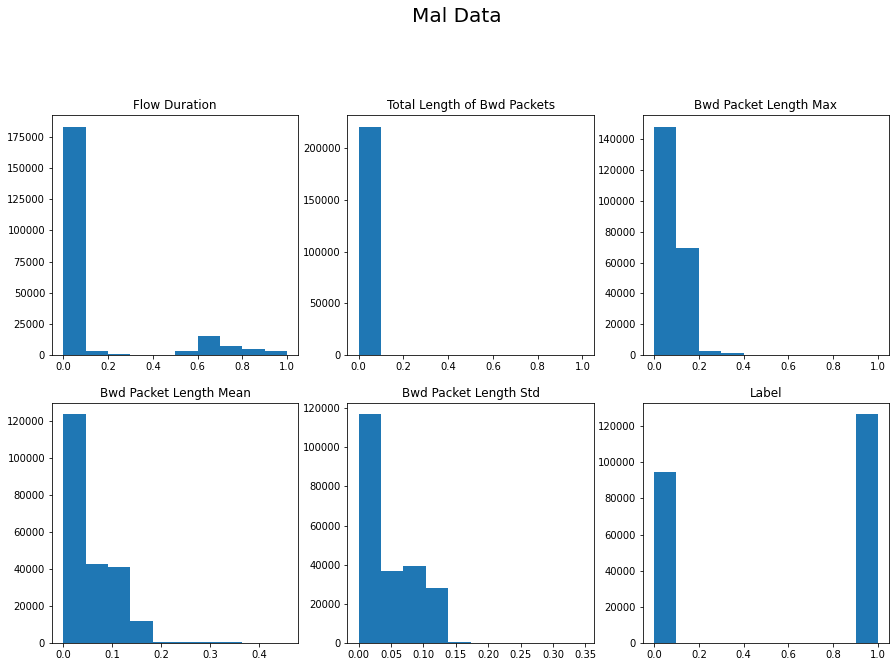

In [12]:
plt.figure(figsize=(15,15))
plt.suptitle('Mal Data', fontsize=20)
for i,col in enumerate(malDf2.columns):
  i = i+1
  plt.subplot(3,3,i)
  plt.hist(malDf2[col], bins=10)
  plt.title(col) 

y_mal2 = malDf2['Label']
X_mal2 = malDf2.drop('Label',axis=1)


X_train_mal2, X_test_mal2, y_train_mal2, y_test_mal2 = train_test_split(X_mal2, y_mal2, test_size=0.3, random_state=0)

clf_mal2 = RandomForestClassifier(n_estimators=100)
clf_mal2.fit(X_train_mal2, y_train_mal2)
print(classification_report(y_test, clf_mal2.predict(X_test)))

In [23]:
attackFeatures = ['Bwd Packet Length Max', 'Bwd Packet Length Mean', 'Bwd Packet Length Std']
mal_mean_low = 0.2
mal_max_low = 0.5
mal_std_low = 0.2

malDf3 = scaled_X_df
df3_featDict = {'Bwd Packet Length Max': mal_max_low,
                'Bwd Packet Length Mean': mal_mean_low,
                'Bwd Packet Length Std': mal_std_low}

for feature in attackFeatures:
  for i, rowVal in enumerate(malDf3[feature]):
    if malDf3.iat[i, 5] == 1.0:
      if(malDf3.iat[i, malDf3.columns.get_loc(feature)] - df3_featDict[feature] >= 0):
        malDf3.iat[i, malDf3.columns.get_loc(feature)] = malDf3.iat[i, malDf3.columns.get_loc(feature)] - df3_featDict[feature]

In [19]:
#scaler1 = MinMaxScaler()
#mal_scaled = scaler1.fit_transform(malDf3)
#mal_scaled_df = pd.DataFrame(mal_scaled, columns=malDf3.columns, index=malDf3.index)

              precision    recall  f1-score   support

         0.0       0.53      0.98      0.69     28476
         1.0       0.96      0.36      0.52     37878

    accuracy                           0.62     66354
   macro avg       0.75      0.67      0.61     66354
weighted avg       0.78      0.62      0.59     66354



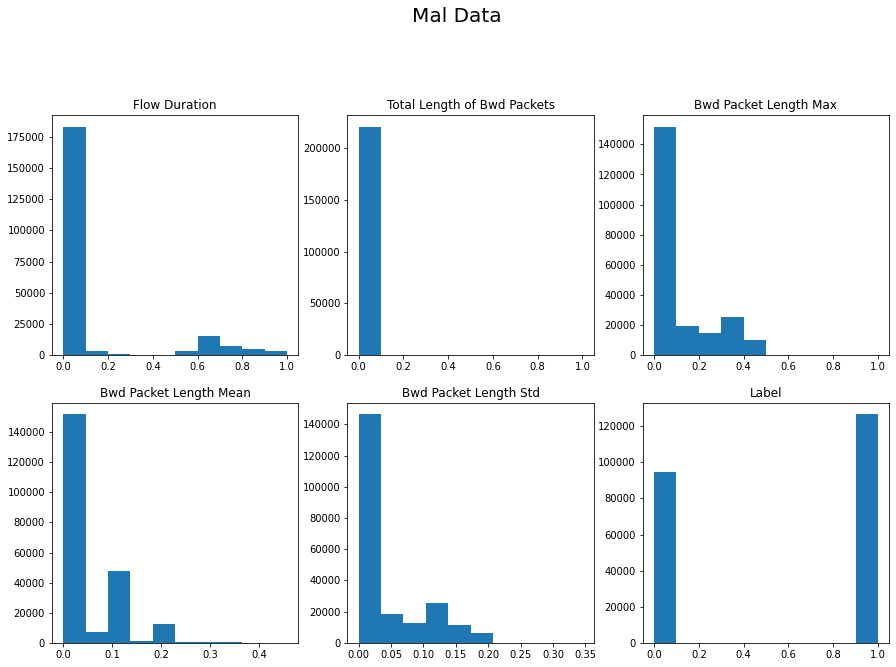

In [24]:
plt.figure(figsize=(15,15))
plt.suptitle('Mal Data', fontsize=20)
for i,col in enumerate(malDf3.columns):
  i = i+1
  plt.subplot(3,3,i)
  plt.hist(malDf3[col], bins=10)
  plt.title(col) 

y_mal3 = malDf3['Label']
X_mal3 = malDf3.drop('Label',axis=1)


X_train_mal3, X_test_mal3, y_train_mal3, y_test_mal3 = train_test_split(X_mal3, y_mal3, test_size=0.3, random_state=0)

clf_mal3 = RandomForestClassifier(n_estimators=100)
clf_mal3.fit(X_train_mal3, y_train_mal3)
print(classification_report(y_test, clf_mal3.predict(X_test)))